## **Libraries**

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
import numpy as np
import joblib

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer


from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


## **Import Dataset**

In [8]:
df_import=pd.read_csv("mbti_dataset.csv")

In [9]:
df_import.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


## **Preprocessing data**

In [10]:
def split_posts(types,post):
    df = pd.DataFrame(columns = ['type','posts'])
    x = post.split("|||")
    posts_div=[]
    string=""
    for ind,val in enumerate(x):
        string = string + " "+ val
        if (ind+1)%25 == 0:
            posts_div.append(string)
            string=""
    for post in posts_div:
        new_row={'type':types,'posts':post}
        df=df.append(new_row,ignore_index=True)
    return df  
            
            

In [11]:
%%time
df = pd.DataFrame(columns = ['type','posts'])
for i in range(len(df_import)):
    df_tmp = split_posts(df_import.loc[i,"type"],df_import.loc[i,"posts"])
    df=df.append(df_tmp,ignore_index=True)

df.head()

CPU times: user 1min 5s, sys: 300 ms, total: 1min 5s
Wall time: 1min 5s


,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw h...
1,INFJ,"Get high in backyard, roast and eat marshmell..."
2,ENTP,'I'm finding the lack of me in these posts ve...
3,ENTP,Sounds pretty much like my area and what I'm ...
4,INTP,'Good one _____ https://www.youtube.com/wa...


In [12]:
print(df_import.shape)
print(df.shape)

(8675, 2)
(16251, 2)


In [13]:
df["target_EI"]=df["type"].apply(lambda row: row[0])
df["target_NS"]=df["type"].apply(lambda row: row[1])
df["target_TF"]=df["type"].apply(lambda row: row[2])
df["target_PJ"]=df["type"].apply(lambda row: row[3])

In [14]:
df.head()

,type,posts,target_EI,target_NS,target_TF,target_PJ
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw h...,I,N,F,J
1,INFJ,"Get high in backyard, roast and eat marshmell...",I,N,F,J
2,ENTP,'I'm finding the lack of me in these posts ve...,E,N,T,P
3,ENTP,Sounds pretty much like my area and what I'm ...,E,N,T,P
4,INTP,'Good one _____ https://www.youtube.com/wa...,I,N,T,P


In [15]:
y1=[]
y2=[]
barWidth = 0.4
r1 = range(len(y1))
r2 = [x + barWidth for x in r1]

In [16]:
y1.append(df["target_EI"].value_counts()[0])
y2.append(df["target_EI"].value_counts()[1])

In [17]:
y1.append(df["target_NS"].value_counts()[0])
y2.append(df["target_NS"].value_counts()[1])

In [18]:
y1.append(df["target_TF"].value_counts()[0])
y2.append(df["target_TF"].value_counts()[1])

In [19]:
y1.append(df["target_PJ"].value_counts()[0])
y2.append(df["target_PJ"].value_counts()[1])

Text(0.5, 1.0, 'Category P/J')

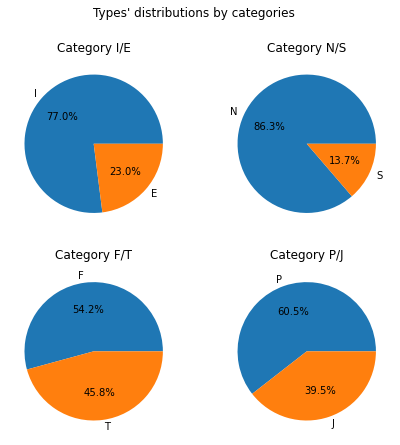

In [20]:
fig,ax = plt.subplots(2,2,figsize=(7,7))
fig.suptitle("Types' distributions by categories")
ax[0, 0].pie([y1[0],y2[0]], labels = ['I', 'E'],autopct='%1.1f%%')
ax[0, 0].set_title('Category I/E')
ax[0, 1].pie([y1[1],y2[1]], labels = ['N', 'S'],autopct='%1.1f%%')
ax[0, 1].set_title('Category N/S')
ax[1, 0].pie([y1[2],y2[2]], labels = ['F', 'T'],autopct='%1.1f%%')
ax[1, 0].set_title('Category F/T')
ax[1, 1].pie([y1[3],y2[3]], labels = ['P', 'J'],autopct='%1.1f%%')
ax[1, 1].set_title('Category P/J')

Categories FT and PJ are quite balanced. Accurracy will be adequate.
However, types E and S are underrepresented in their respective categories, so f1_score will be better these categories.

### **Clean Data**

In [21]:
stop_words = stopwords.words("english")
#create an object of class PorterStemmer
porter = PorterStemmer()

In [22]:
def cleanData(posts):
    # Lowercase
    clean_text = posts.lower()
    #remove all hyperlinks
    clean_text = re.sub(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})','',clean_text)
    word_list = word_tokenize(clean_text)
    clean_posts = []
    for word in word_list:
        if word.isalpha() and word not in stop_words:
            word = porter.stem(word)
            clean_posts.append(word)
    return clean_posts


In [23]:
%%time
df["posts_preprocessed"]= df["posts"].apply(lambda row: cleanData(row))

CPU times: user 5min 15s, sys: 743 ms, total: 5min 15s
Wall time: 5min 16s


In [24]:
df.head()

,type,posts,target_EI,target_NS,target_TF,target_PJ,posts_preprocessed
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw h...,I,N,F,J,"[enfp, intj, moment, sportscent, top, ten, pla..."
1,INFJ,"Get high in backyard, roast and eat marshmell...",I,N,F,J,"[get, high, backyard, roast, eat, marshmellow,..."
2,ENTP,'I'm finding the lack of me in these posts ve...,E,N,T,P,"[find, lack, post, alarm, sex, bore, posit, of..."
3,ENTP,Sounds pretty much like my area and what I'm ...,E,N,T,P,"[sound, pretti, much, like, area, go, right, t..."
4,INTP,'Good one _____ https://www.youtube.com/wa...,I,N,T,P,"[one, cours, say, know, bless, curs, absolut, ..."


## **Models**

### **Vectorization**

In [25]:
cv = CountVectorizer()
tfidf = TfidfVectorizer()

In [26]:
X=df["posts_preprocessed"].map(' '.join)

In [27]:
cnt_vector = cv.fit_transform(X)
tfidf_vector = tfidf.fit_transform(X)

In [28]:
vectors={'cnt_vector':cnt_vector,'tfidf_vector':tfidf_vector}

### **Predictions**

We will test the following classifiers for each category:
 * GaussianNb
 * MultinomialNB
 * LinearSVC
 * LogisticRegression

In [29]:
classifiers = [
    GaussianNB(),
    MultinomialNB(),
    LinearSVC(max_iter=50000,class_weight='balanced'),
    LogisticRegression(max_iter=50000,class_weight='balanced')
    ]

In [30]:
def model_training(target):
    scores={}
    for i in vectors:
        X_train,X_test,y_train,y_test = train_test_split(vectors[i],df[target],test_size=0.2)
        for classifier in classifiers:
            if str(classifier) == "GaussianNB()":
                X_train=X_train.todense()
                X_test=X_test.todense()
            model = classifier.fit(X_train, y_train)
            predictions=model.predict(X_test)
            classification=metrics.classification_report(y_test,predictions,zero_division=0)
            model_name = i +"+"+str(classifier)
            model_name_clean = re.sub(r'\([^)]*\)', '', model_name) #delete text within parentheses
            if target == "target_EI" or target == "target_NS":
                avg=metrics.f1_score(y_test,predictions,zero_division=0,average='macro')
            else:
                avg=metrics.accuracy_score(y_test,predictions)

            scores[model_name_clean]=avg
            print(model_name)
            print(classification)
    return scores

**EI category**:

In [31]:
%%time
EI_f1_scores=model_training("target_EI")

cnt_vector+GaussianNB()
              precision    recall  f1-score   support

           E       0.28      0.27      0.27       747
           I       0.78      0.79      0.79      2504

    accuracy                           0.67      3251
   macro avg       0.53      0.53      0.53      3251
weighted avg       0.67      0.67      0.67      3251

cnt_vector+MultinomialNB()
              precision    recall  f1-score   support

           E       0.57      0.35      0.44       747
           I       0.83      0.92      0.87      2504

    accuracy                           0.79      3251
   macro avg       0.70      0.64      0.65      3251
weighted avg       0.77      0.79      0.77      3251

cnt_vector+LinearSVC(class_weight='balanced', max_iter=50000)
              precision    recall  f1-score   support

           E       0.51      0.51      0.51       747
           I       0.85      0.85      0.85      2504

    accuracy                           0.77      3251
   macro avg   

**NS category:**

In [32]:
%%time
NS_f1_scores=model_training("target_NS")

cnt_vector+GaussianNB()
              precision    recall  f1-score   support

           N       0.86      0.94      0.90      2764
           S       0.23      0.10      0.14       487

    accuracy                           0.81      3251
   macro avg       0.54      0.52      0.52      3251
weighted avg       0.76      0.81      0.78      3251

cnt_vector+MultinomialNB()
              precision    recall  f1-score   support

           N       0.86      0.97      0.91      2764
           S       0.42      0.14      0.21       487

    accuracy                           0.84      3251
   macro avg       0.64      0.55      0.56      3251
weighted avg       0.80      0.84      0.81      3251

cnt_vector+LinearSVC(class_weight='balanced', max_iter=50000)
              precision    recall  f1-score   support

           N       0.90      0.91      0.90      2764
           S       0.45      0.43      0.44       487

    accuracy                           0.84      3251
   macro avg   

**TF category:**

In [33]:
%%time
TF_acc=model_training("target_TF")

cnt_vector+GaussianNB()
              precision    recall  f1-score   support

           F       0.63      0.46      0.54      1780
           T       0.51      0.67      0.58      1471

    accuracy                           0.56      3251
   macro avg       0.57      0.57      0.56      3251
weighted avg       0.58      0.56      0.56      3251

cnt_vector+MultinomialNB()
              precision    recall  f1-score   support

           F       0.82      0.83      0.82      1780
           T       0.79      0.78      0.78      1471

    accuracy                           0.80      3251
   macro avg       0.80      0.80      0.80      3251
weighted avg       0.80      0.80      0.80      3251

cnt_vector+LinearSVC(class_weight='balanced', max_iter=50000)
              precision    recall  f1-score   support

           F       0.79      0.77      0.78      1780
           T       0.73      0.75      0.74      1471

    accuracy                           0.76      3251
   macro avg   

**PJ category:**

In [34]:
%%time
PJ_acc=model_training("target_PJ")

cnt_vector+GaussianNB()
              precision    recall  f1-score   support

           J       0.46      0.55      0.50      1286
           P       0.66      0.57      0.61      1965

    accuracy                           0.56      3251
   macro avg       0.56      0.56      0.56      3251
weighted avg       0.58      0.56      0.57      3251

cnt_vector+MultinomialNB()
              precision    recall  f1-score   support

           J       0.68      0.58      0.63      1286
           P       0.75      0.82      0.78      1965

    accuracy                           0.73      3251
   macro avg       0.72      0.70      0.71      3251
weighted avg       0.72      0.73      0.72      3251

cnt_vector+LinearSVC(class_weight='balanced', max_iter=50000)
              precision    recall  f1-score   support

           J       0.60      0.61      0.61      1286
           P       0.74      0.74      0.74      1965

    accuracy                           0.69      3251
   macro avg   

As said before, we have to look at precision for JP category. It seems that tfidf_vector() + LinearSVC() fit better the category

### **Analysis of models**

We will compare the differents models for each category.
As seen before, for the categories E/I and N/S we are interesting in f1_score results. For T/F and P/J, we are focus on accuracy.

Text(0.5, 1.0, "models' accuracies for P/J category")

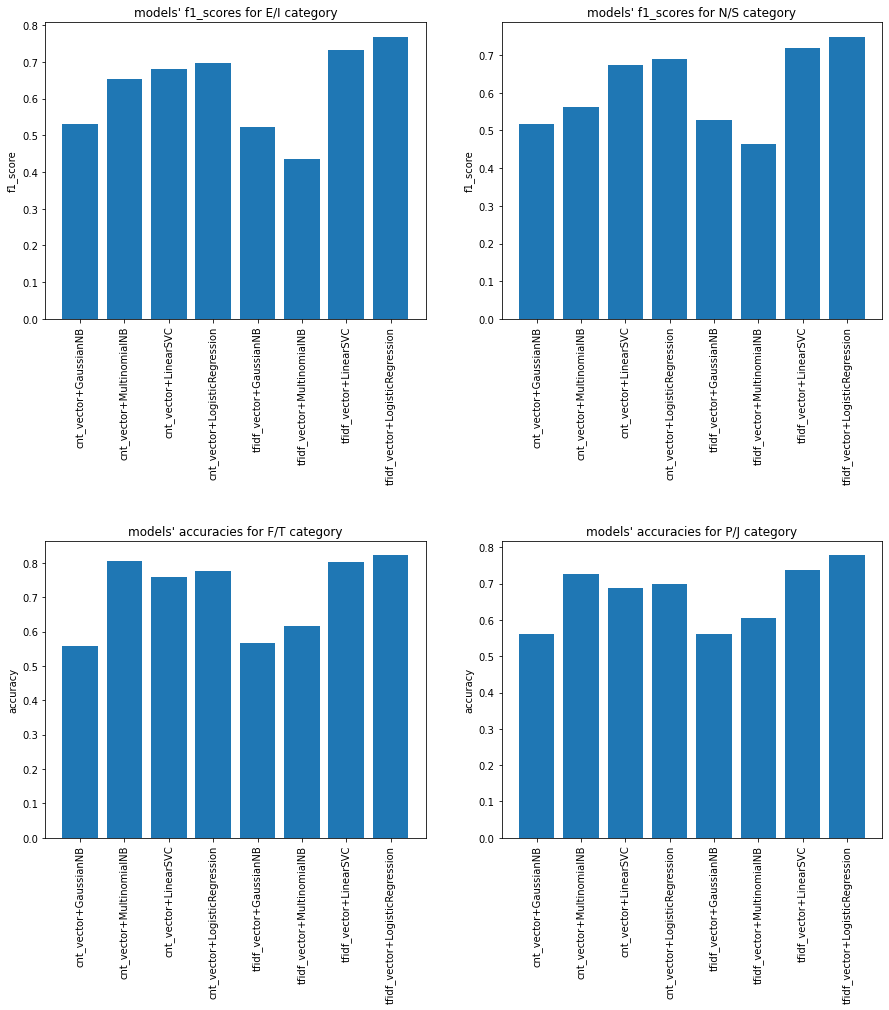

In [35]:
fig,ax = plt.subplots(2,2,figsize=(15,15))
fig.subplots_adjust(hspace=0.75)

ax[0, 0].bar(range(len(EI_f1_scores)),list(EI_f1_scores.values()), align='center')
ax[0, 0].set_xticks(range(len(EI_f1_scores)))
ax[0, 0].set_xticklabels([list(EI_f1_scores.keys())[x] for x in range(len(EI_f1_scores))], rotation=90)
ax[0, 0].set_ylabel("f1_score")
ax[0, 0].set_title("models' f1_scores for E/I category")

ax[0, 1].bar(range(len(NS_f1_scores)), list(NS_f1_scores.values()), align='center')
ax[0, 1].set_xticks(range(len(NS_f1_scores)))
ax[0, 1].set_xticklabels([list(NS_f1_scores.keys())[x] for x in range(len(NS_f1_scores))], rotation=90)
ax[0, 1].set_ylabel("f1_score")
ax[0, 1].set_title("models' f1_scores for N/S category")

ax[1, 0].bar(range(len(TF_acc)), list(TF_acc.values()), align='center')
ax[1, 0].set_xticks(range(len(TF_acc)))
ax[1, 0].set_xticklabels([list(TF_acc.keys())[x] for x in range(len(TF_acc))], rotation=90)
ax[1, 0].set_ylabel("accuracy")
ax[1, 0].set_title("models' accuracies for F/T category")

ax[1, 1].bar(range(len(PJ_acc)), list(PJ_acc.values()), align='center')
ax[1, 1].set_xticks(range(len(PJ_acc)))
ax[1, 1].set_xticklabels([list(PJ_acc.keys())[x] for x in range(len(PJ_acc))], rotation=90)
ax[1, 1].set_ylabel("accuracy")
ax[1, 1].set_title("models' accuracies for P/J category")

**As we can see on the bar charts above, tfidf_vector + LogisticRegression() is the model which fit well all the categories.**

## **Exporting models**

In [36]:
pipe = Pipeline([
        ('vector', TfidfVectorizer()),
        ('regressor', LogisticRegression(max_iter=50000,class_weight='balanced'))
        ])

In [37]:
model_EI = pipe.fit(X, df["target_EI"])
joblib.dump(model_EI, "models/model_EI.joblib")

['models/model_EI.joblib']

In [38]:
model_NS = pipe.fit(X, df["target_NS"])
joblib.dump(model_NS, "models/model_NS.joblib")

['models/model_NS.joblib']

In [39]:
model_TF = pipe.fit(X, df["target_TF"])
joblib.dump(model_TF, "models/model_TF.joblib")

['models/model_TF.joblib']

In [40]:
model_PJ = pipe.fit(X, df["target_PJ"])
joblib.dump(model_PJ, "models/model_PJ.joblib")

['models/model_PJ.joblib']

## **Predictions**

### **Load Models**

In [41]:
pred_EI=joblib.load('models/model_EI.joblib')
pred_NS=joblib.load('models/model_NS.joblib')
pred_TF=joblib.load('models/model_TF.joblib')
pred_PJ=joblib.load('models/model_PJ.joblib')

### **Test**

In [42]:
test_string=['I play football during free time']

In [43]:
result_IE = pred_EI.predict(test_string)
result_NS = pred_NS.predict(test_string)
result_TF = pred_TF.predict(test_string)
result_PJ = pred_PJ.predict(test_string)

In [44]:
print(result_IE[0]+result_NS[0]+result_TF[0]+result_PJ[0])

INTP
